**Spam Filter**
--

**Life cycle of Machine learning Project**

- Understanding the Problem Statement
- Data Collection
- Data Checks to perform
- Exploratory data analysis and Data Pre-Processing
- Model Training
- Choose best model

**1. Problem statement**
--

This project classifies messages as spam and not spam.

**2. Data Collection**
--

- Data Source -  https://www.kaggle.com/datasets/abdallahwagih/spam-emails

- The data consists of 5572 rows and 6 columns

**2.1 Import Data and Required Packages** 
--
**Importing Pandas, Numpy, Matplotlib, Kaggle, Scikit-learn and Scipy Libraries**

In [63]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle 
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout, 
                                     Bidirectional, Input, Concatenate)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import pickle


**Import the DataSet**

In [2]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('abdallahwagih/spam-emails', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/spam-emails


**File information**

In [3]:
print(kaggle.api.dataset_list_files('abdallahwagih/spam-emails').files)

[{"ref": "", "datasetRef": "", "ownerRef": "", "name": "spam.csv", "creationDate": "2023-10-09T23:51:13.575Z", "description": "", "fileType": "", "url": "", "totalBytes": 480130, "columns": []}]


**Import the CSV Data as Pandas DataFrame**

In [4]:
df = pd.read_csv("data/spam.csv")

**Show Top 5 Records**

In [5]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.shape

(5572, 2)

**2.2 Dataset information**
--

This dataset contains a collection of emails, categorized into two classes: "Spam" and "Non-Spam" (often referred to as "Ham"). These emails have been carefully curated and labeled to aid in the development of spam email detection models. Whether you are interested in email filtering, natural language processing, or machine learning, this dataset can serve as a valuable resource for training and evaluation.



**3. Data Checks to perform**
--

- Check Missing values
- Check Duplicates
- Check data type
- Check the number of unique values of each column
- Check statistics of data set
- Check various categories present in the different categorical column

**3.1 Check Missing values**
--

In [7]:
df.isna().sum()

Category    0
Message     0
dtype: int64

**There are no missing values in the data set**

**3.2 Check Duplicates**
--

In [8]:
df.duplicated().sum()

np.int64(415)

**There are 415 duplicates values in the data set**

**Remove duplicates**

In [9]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

**3.3 Check data types**
--

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5157 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5157 non-null   object
 1   Message   5157 non-null   object
dtypes: object(2)
memory usage: 120.9+ KB


**4. Exploratory data analysis and Data Pre-Processing**
--

**Encode Category Column**

In [11]:
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

**4.1 Number of Messages in each group**
--

In [12]:
df['Category'].value_counts()

Category
0    4516
1     641
Name: count, dtype: int64

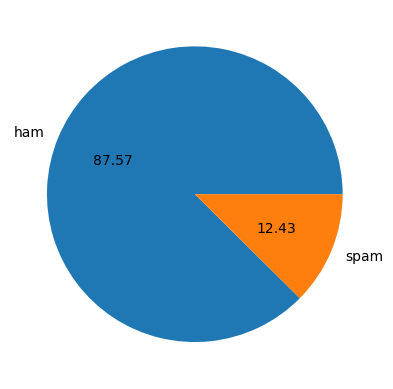

In [13]:

import matplotlib.pyplot as plt
plt.pie(df['Category'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

**Insights:**

There is much more ham than spam in this dataset.

**4.2 Number of characters, words and sentences in each message**
--

In [14]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
df['num_characters'] = df['Message'].apply(len)


In [16]:
df.head()


,Category,Message,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [17]:
df['num_words'] = df['Message'].apply(lambda x:len(word_tokenize(text=x, preserve_line=True)))


In [18]:
df.head()

,Category,Message,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [19]:
df['num_sentences'] = df['Message'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [20]:
df.head()

,Category,Message,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


**4.3 Number of numbers, uppercase words and exclamation marks**
--

In [21]:
df['exclamation_ratio'] = df['Message'].apply(lambda x: x.count('!') / len(x) if len(x) > 0 else 0)
df['uppercase_ratio'] = df['Message'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df['digit_ratio'] = df['Message'].apply(lambda x: sum(1 for c in x if c.isdigit()) / len(x) if len(x) > 0 else 0)

In [22]:
df.head()

,Category,Message,num_characters,num_words,num_sentences,exclamation_ratio,uppercase_ratio,digit_ratio
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,0.0,0.027027,0.00000
1,0,Ok lar... Joking wif u oni...,29,8,2,0.0,0.068966,0.00000
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36,2,0.0,0.064516,0.16129
3,0,U dun say so early hor... U c already then say...,49,13,1,0.0,0.040816,0.00000
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0.0,0.032787,0.00000


**4.4 Data describtion**
--

**Whole data**

In [23]:
df[['num_characters','num_words','num_sentences', 'exclamation_ratio', 'uppercase_ratio', 'digit_ratio']].describe()


,num_characters,num_words,num_sentences,exclamation_ratio,uppercase_ratio,digit_ratio
count,5157.000000,5157.000000,5157.000000,5157.000000,5157.000000,5157.000000
mean,79.103936,17.968780,1.969750,0.002784,0.063666,0.018039
std,58.382922,12.861348,1.455526,0.009040,0.111403,0.048172
min,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,36.000000,9.000000,1.000000,0.000000,0.025000,0.000000
50%,61.000000,14.000000,1.000000,0.000000,0.036364,0.000000
75%,118.000000,25.000000,2.000000,0.000000,0.056604,0.006250
max,910.000000,215.000000,38.000000,0.148148,1.000000,1.000000


**Spam messages**

In [24]:
df[df['Category'] == 1][['num_characters','num_words','num_sentences', 'exclamation_ratio', 'uppercase_ratio', 'digit_ratio']].describe()

,num_characters,num_words,num_sentences,exclamation_ratio,uppercase_ratio,digit_ratio
count,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000
mean,137.118565,26.485179,2.970359,0.005315,0.110670,0.114476
std,30.399707,6.800748,1.485575,0.008801,0.090947,0.071182
min,7.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,130.000000,24.000000,2.000000,0.000000,0.050955,0.071895
50%,148.000000,28.000000,3.000000,0.000000,0.098214,0.114865
75%,157.000000,31.000000,4.000000,0.007353,0.141026,0.154412
max,223.000000,46.000000,9.000000,0.142857,0.785276,0.615385


**Not-spam messages**

In [25]:
df[df['Category'] == 0][['num_characters','num_words','num_sentences', 'exclamation_ratio', 'uppercase_ratio', 'digit_ratio']].describe()

,num_characters,num_words,num_sentences,exclamation_ratio,uppercase_ratio,digit_ratio
count,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000
mean,70.869353,16.759965,1.827724,0.002425,0.056994,0.004350
std,56.708301,13.060773,1.394338,0.009017,0.112436,0.020593
min,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,34.000000,8.000000,1.000000,0.000000,0.024096,0.000000
50%,53.000000,13.000000,1.000000,0.000000,0.034483,0.000000
75%,91.000000,21.000000,2.000000,0.000000,0.047619,0.000000
max,910.000000,215.000000,38.000000,0.148148,1.000000,1.000000


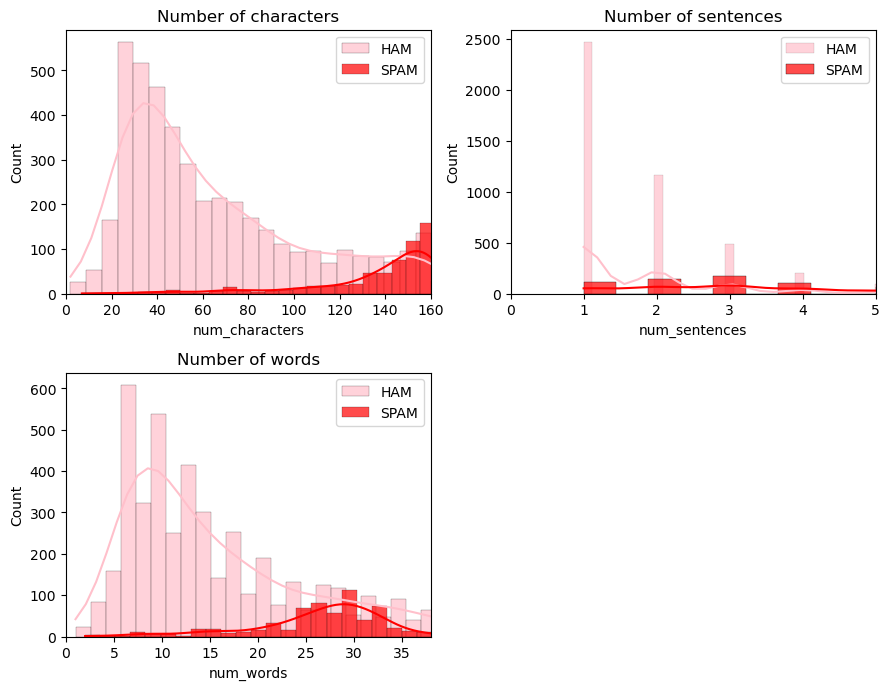

In [26]:
plt.figure(figsize=(9, 10))

plt.subplot(3, 2, 1)
sns.histplot(df[df['Category'] == 0]['num_characters'], color='pink', alpha=0.7, label='HAM', kde=True)
sns.histplot(df[df['Category'] == 1]['num_characters'], color='red', alpha=0.7, label='SPAM', kde=True)
plt.xlim(0, df['num_characters'].quantile(0.95))
plt.ylim(0, None)
plt.title('Number of characters')
plt.legend()

plt.subplot(3, 2, 2)
sns.histplot(df[df['Category'] == 0]['num_sentences'], color='pink', alpha=0.7, label='HAM', kde=True)
sns.histplot(df[df['Category'] == 1]['num_sentences'], color='red', alpha=0.7, label='SPAM', kde=True)
plt.xlim(0, df['num_sentences'].quantile(0.95))
plt.ylim(0, None)
plt.title('Number of sentences')
plt.legend()

plt.subplot(3, 2, 3)
sns.histplot(df[df['Category'] == 0]['num_words'], color='pink', alpha=0.7, label='HAM', kde=True)
sns.histplot(df[df['Category'] == 1]['num_words'], color='red', alpha=0.7, label='SPAM', kde=True)
plt.xlim(0, df['num_words'].quantile(0.95))
plt.ylim(0, None)
plt.title('Number of words')
plt.legend()

plt.tight_layout()
plt.show()

**4.5. Average Feature Values by Category**
--

<Figure size 1200x600 with 0 Axes>

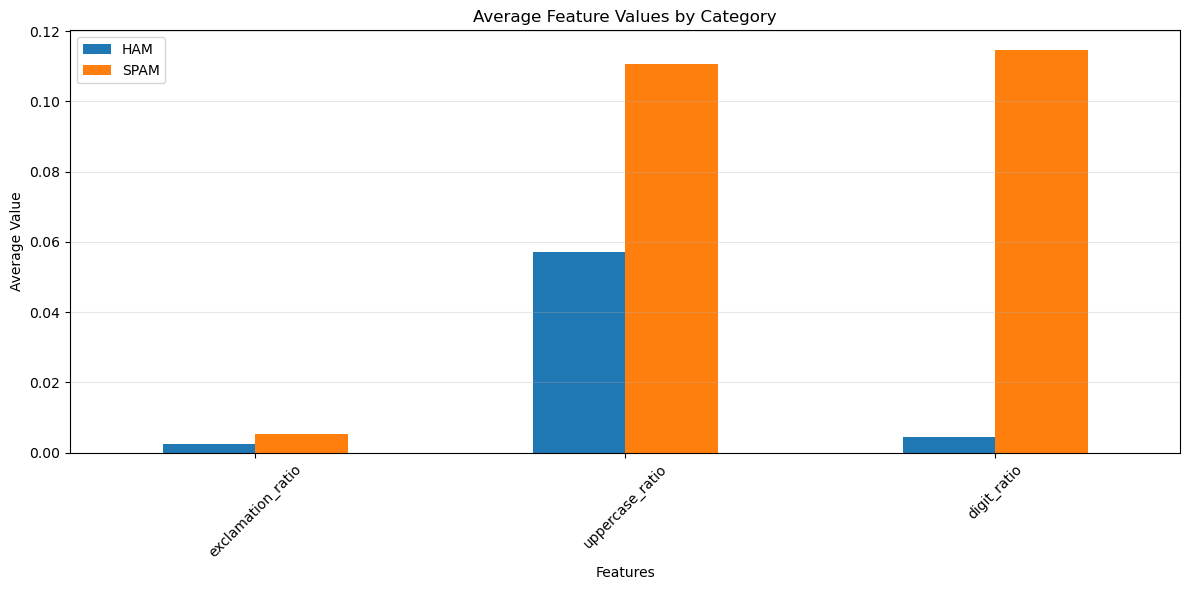

In [27]:
mean_values = df.groupby('Category')[['exclamation_ratio', 'uppercase_ratio', 'digit_ratio']].mean()

plt.figure(figsize=(12, 6))
mean_values.T.plot(kind='bar', figsize=(12, 6))
plt.title('Average Feature Values by Category')
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.legend(['HAM', 'SPAM'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Insights:**

Spam messages contain more exclamation marks, capital letters and numbers.

**4.6. Corelation matrix**
--

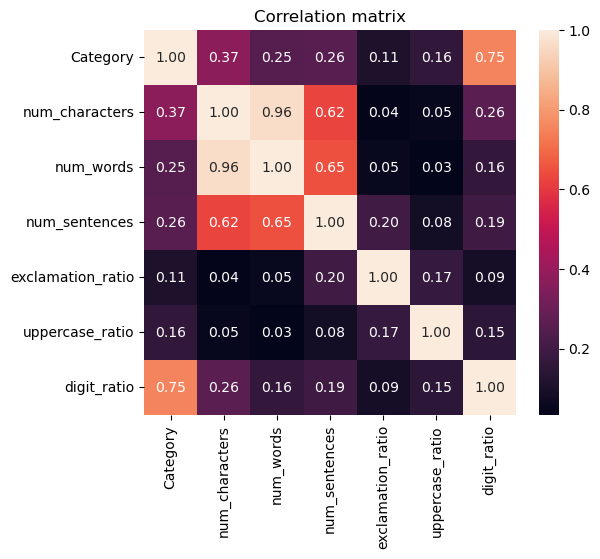

In [28]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation matrix')
plt.show()

**Insights:**

The column that has the greatest impact on the Category column is the digit_count column.

**4.7. Data Preprocessing**
--

- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Stemming

In [29]:
def preprocessing_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words and token not in punctuation:
            filtered_tokens.append(token)

    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return ' '.join(stemmed_tokens)

In [30]:
df['transformed_text'] = df['Message'].apply(preprocessing_text)

In [31]:
df.head()

,Category,Message,num_characters,num_words,num_sentences,exclamation_ratio,uppercase_ratio,digit_ratio,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,0.0,0.027027,0.00000,go jurong point crazi .. avail bugi n great wo...
1,0,Ok lar... Joking wif u oni...,29,8,2,0.0,0.068966,0.00000,ok lar ... joke wif u oni ...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36,2,0.0,0.064516,0.16129,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,0.0,0.040816,0.00000,u dun say earli hor ... u c alreadi say ...
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0.0,0.032787,0.00000,nah n't think goe usf live around though


**4.8. Word Cloud**
--

(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

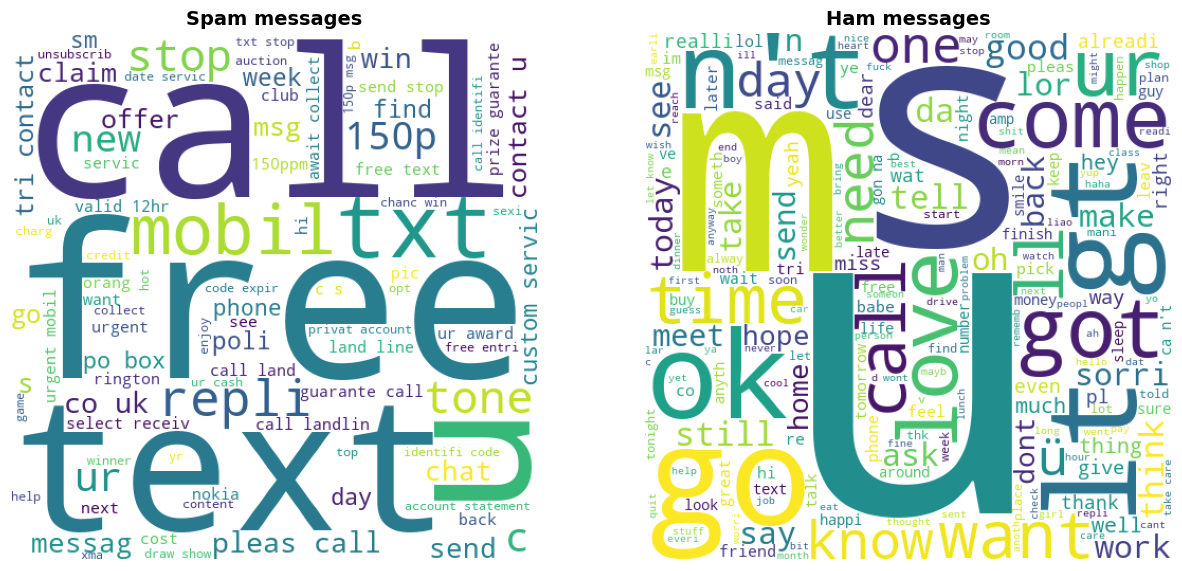

In [32]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
plt.figure(figsize=(15,8))
spam_wc = wc.generate(df[df['Category'] == 1]['transformed_text'].astype(str).str.cat(sep=" "))
plt.subplot(1, 2, 1)
plt.title('Spam messages', fontsize=14, fontweight='bold')
plt.imshow(spam_wc)
plt.axis('off')
ham_wc = wc.generate(df[df['Category'] == 0]['transformed_text'].astype(str).str.cat(sep=" "))
plt.subplot(1, 2, 2)
plt.title('Ham messages', fontsize=14, fontweight='bold')
plt.imshow(ham_wc)
plt.axis('off')


**4.9 Most common words in spam and ham messages**
--

**Spam messages**

In [33]:
spam_corpus = []
for msg in df[df['Category'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [34]:
len(spam_corpus)

10882

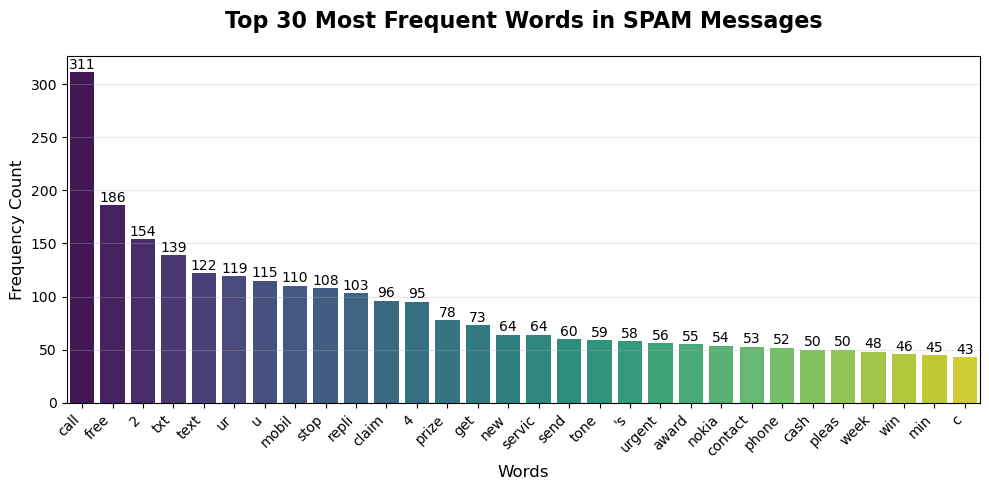

In [35]:
plt.figure(figsize=(10, 5))
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], 
            y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1],
            hue=pd.DataFrame(Counter(spam_corpus).most_common(30))[0],
            legend=False,
            palette='viridis')

plt.title('Top 30 Most Frequent Words in SPAM Messages', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, value in enumerate(pd.DataFrame(Counter(spam_corpus).most_common(30))[1]):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Not-spam messages**

In [36]:
ham_corpus = []
for msg in df[df['Category'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [37]:
len(ham_corpus)


40209

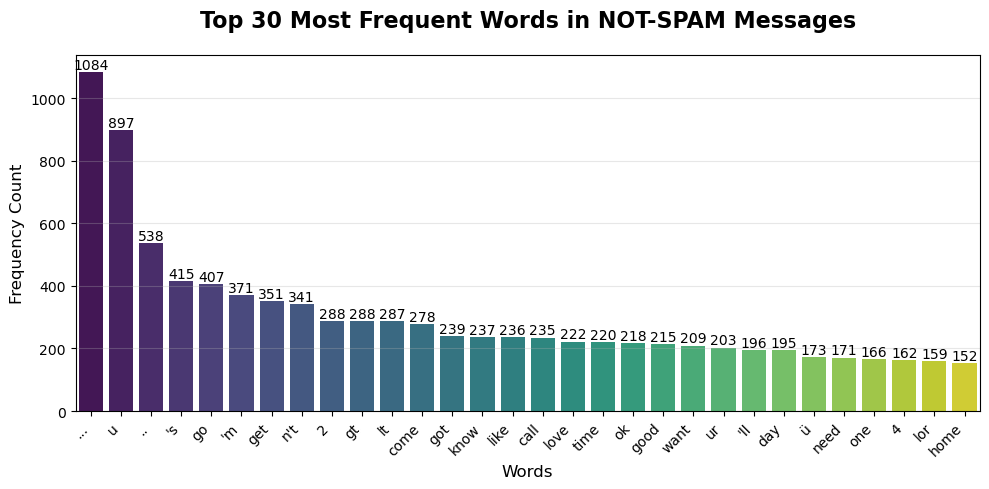

In [38]:
plt.figure(figsize=(10, 5))
sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0], 
            y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1],
            hue=pd.DataFrame(Counter(ham_corpus).most_common(30))[0],
            legend=False,
            palette='viridis')

plt.title('Top 30 Most Frequent Words in NOT-SPAM Messages', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, value in enumerate(pd.DataFrame(Counter(ham_corpus).most_common(30))[1]):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**4.10. Spliting data into training, validation and test sets**
--

In [39]:
X_text = df['transformed_text']
X_numerical = df.drop(['transformed_text', 'Message', 'Category'], axis=1)
y = df['Category']

In [40]:
X_text_temp, X_text_test, X_num_temp, X_num_test, y_temp, y_test = train_test_split(
    X_text, X_numerical, y, test_size=0.15, random_state=42, stratify=y)

X_text_train, X_text_val, X_num_train, X_num_val, y_train, y_val = train_test_split(
    X_text_temp, X_num_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

**4.11. Tokenization - Convert Words to Integers**
--

In [41]:
vocab_size = 10000
max_length = 200

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_text_train)

X_text_train_seq = tokenizer.texts_to_sequences(X_text_train)
X_text_val_seq = tokenizer.texts_to_sequences(X_text_val)
X_text_test_seq = tokenizer.texts_to_sequences(X_text_test)

X_text_train_pad = pad_sequences(X_text_train_seq, maxlen=max_length, padding='post', truncating='post')
X_text_val_pad = pad_sequences(X_text_val_seq, maxlen = max_length, padding='post', truncating='post')
X_text_test_pad = pad_sequences(X_text_test_seq, maxlen=max_length, padding='post', truncating='post')

**4.12. Scale the Numerical Features**
--

In [42]:
scaler = StandardScaler()
scaler.fit(X_num_train)

X_num_train_scaled = scaler.transform(X_num_train)
X_num_val_scaled = scaler.transform(X_num_val)
X_num_test_scaled = scaler.transform(X_num_test)

**5. Model Training**
--

In [43]:
num_feature_count = X_num_train_scaled.shape[1]

def build_model(hp):
    embedding_dim = hp.Int("embedding_dim", min_value=50, max_value=300, step=50)
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=256, step=32)
    use_bidirectional = hp.Boolean("bidirectional")

    numerical_dense_units = hp.Int("num_dense_units", min_value = 8, max_value = 64, step=8)

    n_dense = hp.Int("n_dense", min_value=0, max_value=3, default=1)
    dense_units = hp.Int("dense_units", min_value = 16, max_value = 128, step=16)
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer_choice = hp.Choice("optimizer", values=["adam", "rmsprop", "nadam"])

    if optimizer_choice == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    
    text_input = Input(shape=(max_length,), name='text_input')
    x = Embedding(input_dim = vocab_size, output_dim=embedding_dim)(text_input)

    if use_bidirectional:
        x = Bidirectional(LSTM(lstm_units, dropout=dropout_rate))(x)
    else:
        x = LSTM(lstm_units, dropout=dropout_rate)(x)

    numerical_input = Input(shape=(num_feature_count,), name='numerical_input')
    y = Dense(numerical_dense_units, activation="relu")(numerical_input)
    y = Dropout(dropout_rate)(y)

    combined = Concatenate()([x,y])

    z = combined
    for _ in range(n_dense):
        z = Dense(dense_units, activation="relu")(z)
        z = Dropout(dropout_rate)(z)

    output = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=[text_input, numerical_input], outputs=output)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [44]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="spam_tuning_multi_input",
    project_name="spam_classification",
    overwrite=True
)

tuner.search([X_text_train_pad, X_num_train_scaled], y_train, epochs=20, 
             validation_data=([X_text_val_pad, X_num_val_scaled], y_val),
             callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 5 Complete [00h 12m 52s]
val_accuracy: 0.9533678889274597

Best val_accuracy So Far: 0.9909326434135437
Total elapsed time: 00h 31m 54s


**Top 3 best models**
--

In [ ]:
best_models=tuner.get_best_models(num_models=3)

In [48]:
for i, model in enumerate(best_models):
    print(f"Best model nr. {i+1}")
    print(f"Name: {model.name}")
    print(f"Number of layers: {len(model.layers)}")
    print(f"Number of parametersв: {model.count_params():,}")
    model.summary()

Best model nr. 1
Name: functional
Number of layers: 10
Number of parametersв: 1,820,305


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 150)  │  1,500,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 48)        │        336 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    285,696 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 48)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 304)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 112)       │     34,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 112)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        113 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,820,305 (6.94 MB)

 Trainable params: 1,820,305 (6.94 MB)

 Non-trainable params: 0 (0.00 B)

Best model nr. 2
Name: functional
Number of layers: 12
Number of parametersв: 3,092,089


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  3,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24)        │        168 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     85,248 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 88)        │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 48)        │      4,272 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 48)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 48)        │      2,352 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 48)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         49 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,092,089 (11.80 MB)

 Trainable params: 3,092,089 (11.80 MB)

 Non-trainable params: 0 (0.00 B)

Best model nr. 3
Name: functional
Number of layers: 12
Number of parametersв: 3,394,377


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 250)  │  2,500,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         56 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 448)       │    851,200 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8)         │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 456)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 80)        │     36,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 80)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 80)        │      6,480 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 80)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         81 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,394,377 (12.95 MB)

 Trainable params: 3,394,377 (12.95 MB)

 Non-trainable params: 0 (0.00 B)

**Best Model**
--

In [49]:
best_model = best_models[0]

In [52]:
top3_params = tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

{'embedding_dim': 150,
 'lstm_units': 128,
 'bidirectional': True,
 'num_dense_units': 48,
 'n_dense': 1,
 'dense_units': 112,
 'dropout_rate': 0.4,
 'learning_rate': 0.0015973543149091943,
 'optimizer': 'rmsprop'}

In [53]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 0 summary
Hyperparameters:
embedding_dim: 150
lstm_units: 128
bidirectional: True
num_dense_units: 48
n_dense: 1
dense_units: 112
dropout_rate: 0.4
learning_rate: 0.0015973543149091943
optimizer: rmsprop
Score: 0.9909326434135437


In [ ]:
best_trial.metrics.get_last_value("val_accuracy")

np.float64(0.9909326434135437)

In [56]:
history = best_model.fit(
    [X_text_train_pad, X_num_train_scaled], 
    y_train, 
    epochs=20,
    validation_data=([X_text_val_pad, X_num_val_scaled], y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1)
    ],
    verbose=1
)

test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(
    [X_text_test_pad, X_num_test_scaled], 
    y_test,
    verbose=1
)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.9994 - loss: 0.0011 - precision: 1.0000 - recall: 0.9955 - val_accuracy: 0.9883 - val_loss: 0.0706 - val_precision: 0.9677 - val_recall: 0.9375 - learning_rate: 3.9934e-04
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 0.9994 - loss: 0.0010 - precision: 0.9956 - recall: 1.0000 - val_accuracy: 0.9909 - val_loss: 0.0745 - val_precision: 0.9890 - val_recall: 0.9375 - learning_rate: 3.9934e-04
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 244ms/step - accuracy: 0.9997 - loss: 0.0024 - precision: 0.9978 - recall: 1.0000 - val_accuracy: 0.9909 - val_loss: 0.0758 - val_precision: 0.9890 - val_recall: 0.9375 - learning_rate: 1.9967e-04
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 270ms/step - accuracy: 0.9992 - loss: 0.0056 - precision: 0.9978 - recall: 0.9955 - val_accuracy: 0.9896 - val_loss: 0.0748 - val_precision: 0.9783 - val_recall: 0.9375 - learning_rate: 9.9835e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/

In [ ]:
print(f"\nResults:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Results:
Test Loss: 0.1217
Test Accuracy: 0.9858
Test Precision: 0.9570
Test Recall: 0.9271


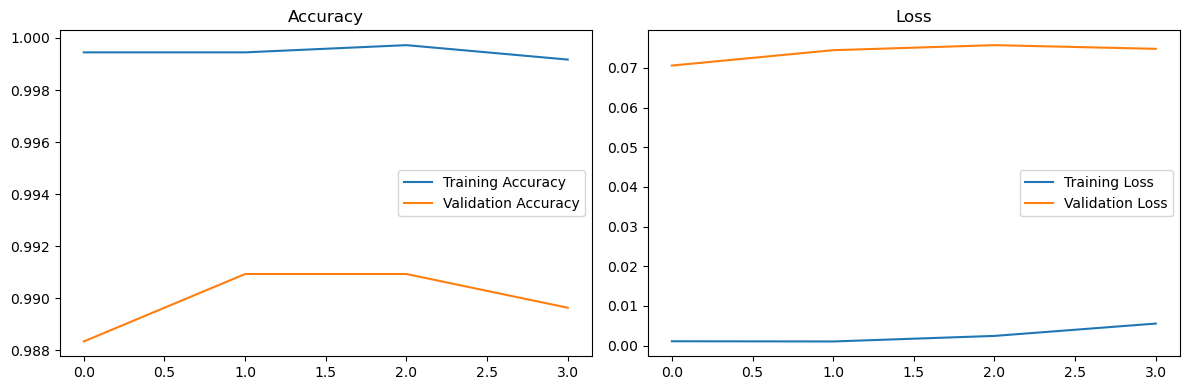

In [58]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Prediction on test set**
--

In [60]:
y_pred_proba = best_model.predict([X_text_test_pad, X_num_test_scaled])
y_pred = (y_pred_proba > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
Confusion Matrix:
[[674   4]
 [  7  89]]


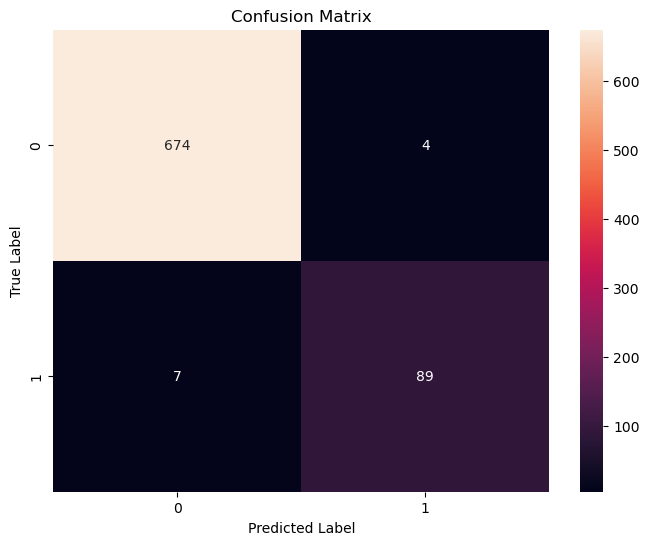

In [61]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [62]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       678
           1       0.96      0.93      0.94        96

    accuracy                           0.99       774
   macro avg       0.97      0.96      0.97       774
weighted avg       0.99      0.99      0.99       774



**Saving Model**
--

In [65]:
best_model.save('spam_classifier_final.keras')

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)